In [3]:
import import_ipynb
import data_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap

u4_control_vars = ['tot_activepower', 'plant_tmp', 'ext_tmp', 'canal_level', 'canal_tmp', 'lake_tmp', 'coupler_position', 'injector12_pressure', 'injector34_pressure', 'pump_rotspeed', 'turbine_rotspeed', 'turbine_cycle_id', 'pump_cycle_id', 'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin', 'dayofweek_cos', 'scaled_injector_sum', 'tot_activepower_lag_1', 'tot_activepower_lag_3', 'tot_activepower_lag_10', 'plant_tmp_lag_1', 'plant_tmp_lag_3', 'plant_tmp_lag_10', 'ext_tmp_lag_1', 'ext_tmp_lag_3', 'ext_tmp_lag_10', 'canal_level_lag_1', 'canal_level_lag_3', 'canal_level_lag_10', 'canal_tmp_lag_1', 'canal_tmp_lag_3', 'canal_tmp_lag_10', 'lake_tmp_lag_1', 'lake_tmp_lag_3', 'lake_tmp_lag_10', 'coupler_position_lag_1', 'coupler_position_lag_3', 'coupler_position_lag_10', 'injector12_pressure_lag_1', 'injector12_pressure_lag_3', 'injector12_pressure_lag_10', 'injector34_pressure_lag_1', 'injector34_pres

In [4]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [5]:
train_dataset = u5_train_equil_pump
test_dataset = u5_s02_equil_pump

In [6]:
features = ['tot_activepower', 'ext_tmp', 'plant_tmp', 'coupler_position', 'pump_calculated_flow', 
            'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed', 
            'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'turbine_cycle_id', 
            'pump_cycle_id', 'scaled_injector_sum',
            'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin', 'dayofweek_cos',
            # 'minute', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear',
            # 'tot_activepower_lag_1', 'tot_activepower_lag_3', 
            # 'tot_activepower_lag_10', 'ext_tmp_lag_1', 'ext_tmp_lag_3', 'ext_tmp_lag_10', 
            # 'plant_tmp_lag_1', 'plant_tmp_lag_3', 'plant_tmp_lag_10', 'coupler_position_lag_1', 
            # 'coupler_position_lag_3', 'coupler_position_lag_10', 'pump_calculated_flow_lag_1', 
            # 'pump_calculated_flow_lag_3', 'pump_calculated_flow_lag_10', 'pump_pressure_diff_lag_1', 
            # 'pump_rotspeed_lag_1', 'pump_rotspeed_lag_3', 'pump_rotspeed_lag_10', 'turbine_pressure_lag_1', 
            # 'turbine_pressure_lag_3', 'turbine_pressure_lag_10', 'turbine_rotspeed_lag_1', 
            # 'turbine_rotspeed_lag_3', 'turbine_rotspeed_lag_10', 'water_primary_pump_01_opening_lag_1', 
            # 'water_primary_pump_01_opening_lag_3', 'water_primary_pump_01_opening_lag_10', 
            # 'water_primary_pump_02_opening_lag_1', 'water_primary_pump_02_opening_lag_3', 
            # 'water_primary_pump_02_opening_lag_10', 'turbine_cycle_id_lag_1', 'turbine_cycle_id_lag_3', 
            # 'turbine_cycle_id_lag_10', 'pump_cycle_id_lag_1', 'pump_cycle_id_lag_3', 'pump_cycle_id_lag_10'
        ]


In [7]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in train_dataset.columns]

target_features = ['charge', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'air_circ_cold_01_tmp', 
    'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 
    'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 
    'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 
    'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 
    'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 
    'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coil_ph01_03_tmp', 'stat_coil_ph01_04_tmp', 
    'stat_coil_ph01_05_tmp', 'stat_coil_ph01_06_tmp', 'stat_coil_ph02_01_tmp', 'stat_coil_ph02_02_tmp', 
    'stat_coil_ph02_03_tmp', 'stat_coil_ph02_04_tmp', 'stat_coil_ph02_05_tmp', 'stat_coil_ph02_06_tmp', 
    'stat_coil_ph03_01_tmp', 'stat_coil_ph03_02_tmp', 'stat_coil_ph03_03_tmp', 'stat_coil_ph03_04_tmp', 
    'stat_coil_ph03_05_tmp', 'stat_coil_ph03_06_tmp', 'stat_magn_01_tmp', 'stat_magn_02_tmp', 
    'stat_magn_03_tmp', 'stat_magn_04_tmp', 'stat_magn_05_tmp', 'stat_magn_06_tmp', 'stat_magn_07_tmp', 
    'stat_magn_08_tmp', 'stat_magn_09_tmp', 'stat_magn_10_tmp', 'stat_magn_11_tmp', 'stat_magn_12_tmp', 
    'water_circ_cold_tmp', 'water_circ_flow', 'water_circ_hot_01_tmp', 'water_circ_hot_02_tmp', 
    'water_circ_hot_03_tmp', 'water_circ_hot_04_tmp', 'water_circ_hot_05_tmp', 'water_circ_hot_06_tmp', 
    'water_circ_hot_tmp', 'air_gap_negative_x_position', 'air_gap_positive_x_position', 
    'air_gap_negative_y_position', 'air_gap_positive_y_position'
    ]

# Split the data into source and target sets (we will regress the source variables onto the target variables)
train = train_dataset[features]
y = train_dataset[target_features]

In [8]:
# import optuna
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import root_mean_squared_error
# from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)

# # Define the objective function for Optuna
# def objective(trial):
#     # Define the hyperparameters to tune
#     # n_estimators = trial.suggest_int('n_estimators', 10, 100)
#     n_estimators = trial.suggest_int('n_estimators', 3, 20)
#     max_depth = trial.suggest_int('max_depth', 3, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # 'auto' removed

#     # Create the RandomForestRegressor with the suggested hyperparameters
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )

#     # Train the model
#     model.fit(X_train, y_train)

#     # Predict on the validation set
#     y_val_pred = model.predict(X_val)

#     # Calculate RMSE as the evaluation metric
#     rmse = root_mean_squared_error(y_val, y_val_pred)
#     return rmse


# # Create an Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # Number of trials

# # Print the best hyperparameters
# print("Best hyperparameters:", study.best_params)

# # Train the final model with the best hyperparameters
# best_params = study.best_params

Best hyperparameters: {'n_estimators': 20, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [9]:
# # If ran the optuna study before
# best_params = study.best_params 

# Otherwise
best_params = {'n_estimators': 20, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}

In [10]:
final_model = RandomForestRegressor(
    # n_estimators=15,
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

final_model.fit(train, y)

RandomForestRegressor(max_depth=25, max_features=None, n_estimators=20,
                      random_state=42)

In [11]:
# Predict on the test set
y_pred = final_model.predict(train)

residuals = y - y_pred

# Compute the residual norm for each timestamp in the training data
residuals_norm = np.linalg.norm(residuals, axis=1)

# Define your threshold. For example, using mean + 4 * std:
mean_norm = np.mean(residuals_norm)
std_norm = np.std(residuals_norm)
threshold = mean_norm + 1 * std_norm

# Test

In [12]:
# For the synthetic test set:
X_synthetic = test_dataset[features]
y_synthetic = test_dataset[target_features]  # target is now multi-dimensional
y_pred_synthetic = final_model.predict(X_synthetic)
residuals_synthetic = y_pred_synthetic - y_synthetic  # shape: (n_samples, n_target_features)

# Compute the norm of the synthetic test residuals
residuals_synthetic_norm = np.linalg.norm(residuals_synthetic, axis=1)

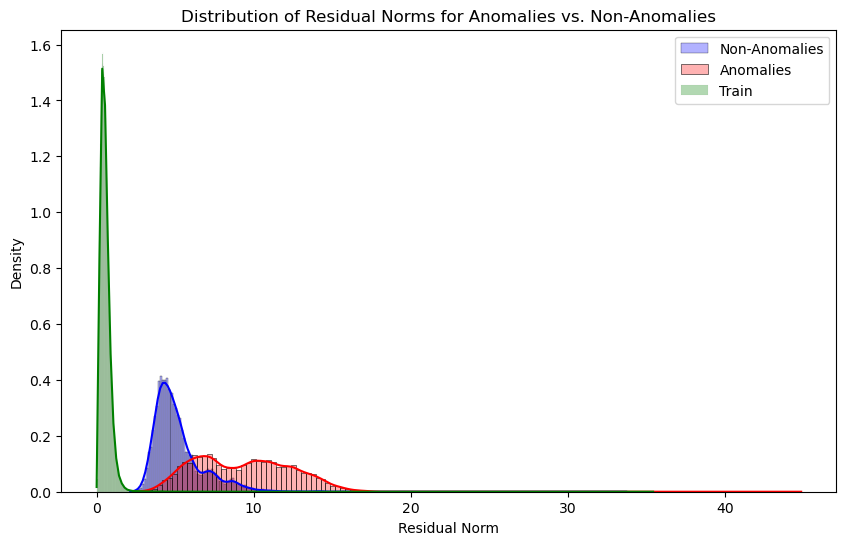

In [13]:
true_anomalies = test_dataset['anomaly']
anomalies = residuals_synthetic_norm[true_anomalies == 1]
non_anomalies = residuals_synthetic_norm[true_anomalies == 0]

plt.figure(figsize=(10, 6))
sns.histplot(non_anomalies, kde=True, color='blue', label='Non-Anomalies', stat='density', alpha=0.3)
sns.histplot(anomalies, kde=True, color='red', label='Anomalies', stat='density', alpha=0.3)
sns.histplot(residuals_norm, kde=True, color="green", label="Train", stat='density', alpha=0.3)

plt.xlabel('Residual Norm')
plt.ylabel('Density')
plt.title('Distribution of Residual Norms for Anomalies vs. Non-Anomalies')
# plt.yscale('log')
# plt.xscale('log')
# plt.xticks([])
plt.legend()
plt.show()

In [14]:
# Assume you have 'true_anomalies' and 'residuals_synthetic_norm' defined
fpr, tpr, thresholds = roc_curve(true_anomalies, residuals_synthetic_norm)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

# Calculate F1-score for each possible threshold
f1_scores = []
for threshold in thresholds:
    predicted_anomalies = (residuals_synthetic_norm >= threshold).astype(int)
    f1 = f1_score(true_anomalies, predicted_anomalies)
    f1_scores.append(f1)

# Find the threshold that maximized the F1-score
max_f1_index = np.argmax(f1_scores)
max_f1 = f1_scores[max_f1_index]
best_threshold = thresholds[max_f1_index]

print("Best Threshold:", best_threshold)
print("Max F1-score:", max_f1)

AUC: 0.897970164925746
Best Threshold: 5.451508206442379
Max F1-score: 0.8733360638951464


AUC: 0.897970164925746


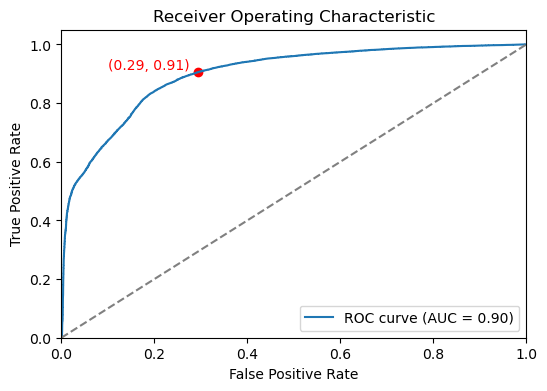

In [15]:
# ROC Curve and AUC
# Use the continuous residual norm as the "score" for ROC
fpr, tpr, thresholds = roc_curve(true_anomalies, residuals_synthetic_norm)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

# Plot the ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0,1], [0,1], '--', color='gray')
plt.scatter(fpr[max_f1_index], tpr[max_f1_index], color='red')  # mark the point of the best threshold
plt.text(fpr[max_f1_index] - 0.02, tpr[max_f1_index]+0.01, f"({fpr[max_f1_index]:.2f}, {tpr[max_f1_index]:.2f})",
         color='red', ha='right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

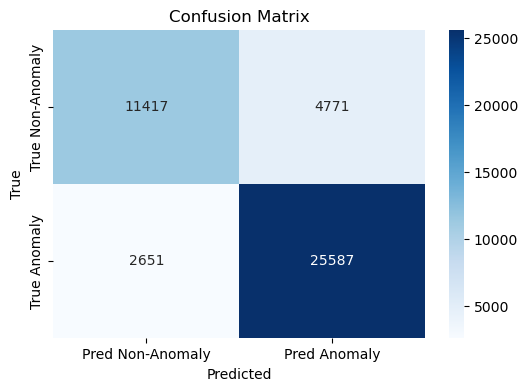

Accuracy: 0.8329356683023454
F1-score: 0.8733360638951464
 R squared: 0.27867491985810966


In [16]:
# Using the best threshold for final predictions and performance metrics
predicted_anomalies = (residuals_synthetic_norm >= best_threshold).astype(int)
acc = accuracy_score(true_anomalies, predicted_anomalies)
f1 = f1_score(true_anomalies, predicted_anomalies)
r2 = r2_score(true_anomalies, predicted_anomalies)
cm = confusion_matrix(true_anomalies, predicted_anomalies)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Non-Anomaly', 'Pred Anomaly'], 
            yticklabels=['True Non-Anomaly', 'True Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", acc)
print("F1-score:", f1)
print(" R squared:", r2)

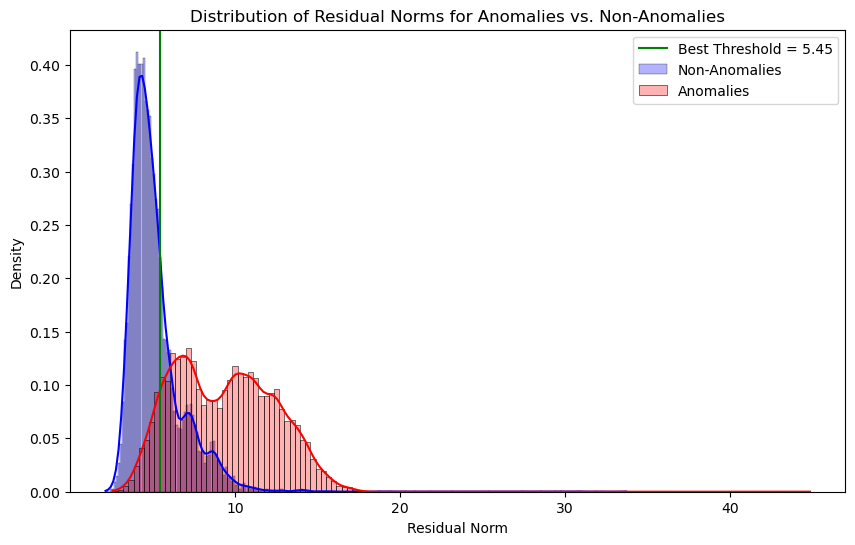

In [17]:
anomalies = residuals_synthetic_norm[true_anomalies == 1]
non_anomalies = residuals_synthetic_norm[true_anomalies == 0]

plt.figure(figsize=(10, 6))
sns.histplot(non_anomalies, kde=True, color='blue', label='Non-Anomalies', stat='density', alpha=0.3)
sns.histplot(anomalies, kde=True, color='red', label='Anomalies', stat='density', alpha=0.3)
plt.axvline(x=best_threshold, color='green', linestyle='-', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('Residual Norm')
plt.ylabel('Density')
plt.title('Distribution of Residual Norms for Anomalies vs. Non-Anomalies')
plt.legend()
plt.show()

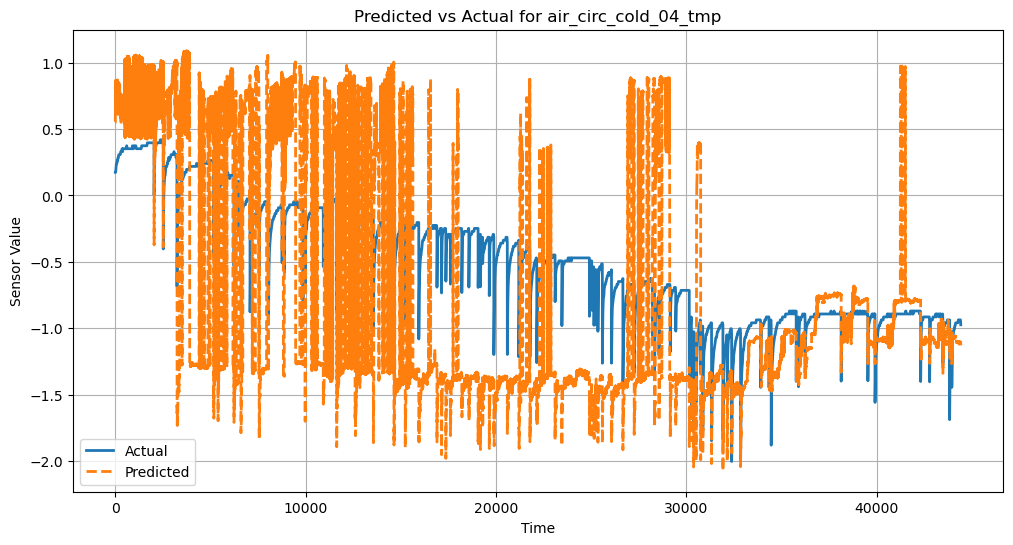

In [18]:
# Specify the sensor (output dimension) you want to visualize
sensor_name = 'air_circ_cold_04_tmp'  # Replace with the name of the sensor

# Extract the actual and predicted values for the chosen sensor
actual_values = y_synthetic[sensor_name].values  # True values for the sensor
predicted_values = y_pred_synthetic[:, y_synthetic.columns.get_loc(sensor_name)]  # Predicted values

# Plot the actual and predicted time series
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual', linewidth=2)
plt.plot(predicted_values, label='Predicted', linewidth=2, linestyle='--')
plt.title(f'Predicted vs Actual for {sensor_name}')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True)
plt.show()